In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.externals import joblib

from sklearn.utils import shuffle
sys.path.append( os.getcwd()+'/modules' )
import aux_functions

In [2]:
#Loading datasets
path = os.getcwd() 
os.chdir( "/home/toful/Documents/DataSets/cresci-2017.csv/datasets_full.csv/" )

real = pd.read_csv( 'genuine_accounts.csv/genuine_accounts.csv/users.csv' )
real = real.fillna( '' )
real['knownbot'] = 0

fakeFollowers = pd.read_csv('fake_followers.csv/fake_followers.csv/users.csv', na_filter=False)
fakeFollowers = fakeFollowers.fillna( '' )
fakeFollowers['knownbot'] = 1

socialSpamBots1 = pd.read_csv('social_spambots_1.csv/social_spambots_1.csv/users.csv', na_filter=False)
socialSpamBots1 = socialSpamBots1.fillna( '' )
socialSpamBots1['knownbot'] = 1

socialSpamBots2 = pd.read_csv('social_spambots_2.csv/social_spambots_2.csv/users.csv', na_filter=False)
socialSpamBots2 = socialSpamBots2.fillna( '' )
socialSpamBots2['knownbot'] = 1

socialSpamBots3 = pd.read_csv('social_spambots_3.csv/social_spambots_3.csv/users.csv', na_filter=False)
socialSpamBots3 = socialSpamBots3.fillna( '' )
socialSpamBots3['knownbot'] = 1

df_list = []

df_list += [ shuffle( pd.concat( [ real, fakeFollowers ], sort=False ) ) ]
df_list += [ shuffle( pd.concat( [ real, socialSpamBots1, socialSpamBots2, socialSpamBots3 ], sort=False ) ) ]
df_list += [ shuffle( pd.concat( [ real, fakeFollowers, socialSpamBots1, socialSpamBots2, socialSpamBots3 ], sort=False ) ) ]

fakeFollowers['knownbot'] = 2
df_list += [ shuffle( pd.concat( [ real, fakeFollowers, socialSpamBots1, socialSpamBots2, socialSpamBots3 ], sort=False ) ) ]
#df = shuffle( df )
#print df.head()
#print df.info()

os.chdir( path )


In [3]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 1289 to 1642
Data columns (total 43 columns):
id                                    6825 non-null int64
name                                  6825 non-null object
screen_name                           6825 non-null object
statuses_count                        6825 non-null int64
followers_count                       6825 non-null int64
friends_count                         6825 non-null int64
favourites_count                      6825 non-null int64
listed_count                          6825 non-null int64
url                                   6825 non-null object
lang                                  6825 non-null object
time_zone                             6825 non-null object
location                              6825 non-null object
default_profile                       6825 non-null object
default_profile_image                 6825 non-null object
geo_enabled                           6825 non-null object
profile_ima

In [4]:
print( os.getcwd()  )

/home/toful/Dropbox/Uni/5e_Curs/TFG_I/BotDetector/src


In [3]:
#Building the working datasets
score_list = []
for df in df_list:
    score = pd.DataFrame()
    score['id'] = df['id']

    #score['lang-en'] = df.apply( lambda row: aux_functions.language (row), axis=1 )
    score['profile_pic'] = df.apply( lambda row: aux_functions.profile_image (row), axis=1 ) #check this feature
    score['def_profile_pic'] = df.apply( lambda row: aux_functions.def_profile_image (row), axis=1 )
    score['has_screen_name'] = df.apply( lambda row: aux_functions.screen_name (row), axis=1 )
    score['30followers'] = df.apply( lambda row: aux_functions.min_followers (row, 30), axis=1 )
    score['1000followers'] = df.apply( lambda row: aux_functions.min_followers2 (row, 1000), axis=1 )
    score['1000friends'] = df.apply( lambda row: aux_functions.min_friends (row, 1000), axis=1 )
    score['30friends'] = df.apply( lambda row: aux_functions.min_friends2 (row, 30), axis=1 )
    score['twice_num_followers'] = df.apply( lambda row: aux_functions.ratio_followers (row), axis=1 )
    score['fifty_FriendsFollowersRatio'] = df.apply( lambda row: aux_functions.ratio_followers2 (row, 50), axis=1 )
    score['hundred_FriendsFollowersRatio'] = df.apply( lambda row: aux_functions.ratio_followers2 (row, 100), axis=1 )
    score['geoloc'] = df.apply( lambda row: aux_functions.location (row), axis=1 )
    score['banner_link'] = df.apply( lambda row: aux_functions.profile_banner (row), axis=1 )
    score['50tweets'] = df.apply( lambda row: aux_functions.tweets_written (row, 50), axis=1 )
    score['20statuses'] = df.apply( lambda row: aux_functions.min_statuses (row, 20), axis=1 )
    score['NeverTweeted'] = df.apply( lambda row: aux_functions.never_tweeted (row ), axis=1 )
    score['has_description'] = df.apply( lambda row: aux_functions.description (row), axis=1 )
    score['knownbot'] = df.apply( lambda row: aux_functions.knownbot (row), axis=1 )

    print score.shape
    print score.describe()
    print score.columns.values
    score_list += [ score ]
    #score

(6825, 18)
                 id  profile_pic  def_profile_pic  has_screen_name  \
count  6.825000e+03       6825.0      6825.000000      6825.000000   
mean   8.499737e+08          0.0         0.002784         0.000147   
std    7.662248e+08          0.0         0.052693         0.012105   
min    6.780330e+05          0.0         0.000000         0.000000   
25%    2.597067e+08          0.0         0.000000         0.000000   
50%    6.168972e+08          0.0         0.000000         0.000000   
75%    1.174963e+09          0.0         0.000000         0.000000   
max    3.164942e+09          0.0         1.000000         1.000000   

       30followers  1000followers  1000friends    30friends  \
count  6825.000000    6825.000000  6825.000000  6825.000000   
mean      0.492601       0.105788     0.076337     0.024469   
std       0.499982       0.307588     0.265556     0.154511   
min       0.000000       0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000

(11737, 18)
                 id  profile_pic  def_profile_pic  has_screen_name  \
count  1.173700e+04      11737.0     11737.000000     11737.000000   
mean   1.263988e+09          0.0         0.005623         0.000085   
std    9.364116e+08          0.0         0.074780         0.009230   
min    6.780330e+05          0.0         0.000000         0.000000   
25%    4.662568e+08          0.0         0.000000         0.000000   
50%    1.127956e+09          0.0         0.000000         0.000000   
75%    2.357009e+09          0.0         0.000000         0.000000   
max    3.164942e+09          0.0         1.000000         1.000000   

        30followers  1000followers   1000friends     30friends  \
count  11737.000000   11737.000000  11737.000000  11737.000000   
mean       0.611741       0.105734      0.108631      0.053421   
std        0.487375       0.307510      0.311189      0.224881   
min        0.000000       0.000000      0.000000      0.000000   
25%        0.000000       0

# Data Analisis

In [4]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

In [5]:
#Preparing the X and Y values for the machine learning analisis
yy=[]
XX=[]
for score in score_list:
    if 'knownbot' in score:
        y = score['knownbot'].values # get the labels we want
        X = score
        del X['knownbot']
        del X['id']
        X = X.values # use everything else to predict
        yy += [y]
        XX += [X]

In [8]:
for elem in score_list[0].columns.values:
    print elem

profile_pic
def_profile_pic
has_screen_name
30followers
1000followers
1000friends
30friends
twice_num_followers
fifty_FriendsFollowersRatio
hundred_FriendsFollowersRatio
geoloc
banner_link
50tweets
20statuses
NeverTweeted
has_description


# RF analysis

In [9]:
def train_model( X, y, name ):
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )

    # first we create a reusable logisitic regression and random forest objects
    lr_clf = LogisticRegression( penalty='l2', C=1.0, class_weight=None ) # get object
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split( X, y ):
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        #lr_clf.fit( X_train, y_train ) # train object
        #y_pred = lr_clf.predict( X_test ) # get test set precitions

        rf_clf.fit( X_train, y_train ) # train object
        y_pred = rf_clf.predict( X_test ) # get test set precitions
        acc = mt.accuracy_score( y_test, y_pred )
        cmat = mt.confusion_matrix( y_test, y_pred )
        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        print "\n====Iteration",iter_num," ===="
        print "RANDOM FOREST"        
        print( mt.classification_report( y_test, y_pred ) )
        print "Accuracy Rate: ", acc
        print('Misclassification Rate: {}'.format( np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) ) ) )
        print('\nTP - True Negative {}'.format(cmat[0,0]))
        print('FP - False Positive {}'.format(cmat[0,1]))
        print('FN - False Negative {}'.format(cmat[1,0]))
        print('TP - True Positive {}'.format(cmat[1,1]))
        
        iter_num+=1
    # save the model to disk
    #if not os.path.exists( 'models' ):
    #    os.makedirs( 'models' )
    #str_ = 'models/randomForest_' + name + '_model.sav'
    #print( "Saving the model into the disk\n" )
    #joblib.dump( rf_clf, str_ )

In [10]:
names = [ 'fakeFollowers', 'spamBots', 'mix' ]
for i in range( len( names ) ):
    print( "Creating a model to detect:" + names[i] )
    train_model( XX[i], yy[i], names[i] )

Creating a model to detect:fakeFollowers

====Iteration 0  ====
RANDOM FOREST
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       688
           1       0.98      0.95      0.97       677

   micro avg       0.97      0.97      0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365

Accuracy Rate:  0.9677655677655678
Misclassification Rate: 0.0322344322344

TP - True Negative 676
FP - False Positive 12
FN - False Negative 32
TP - True Positive 645

====Iteration 1  ====
RANDOM FOREST
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       680
           1       0.97      0.97      0.97       685

   micro avg       0.97      0.97      0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365

Accuracy Rate:  0.9677655677655678
Misclassification Rate: 0.03

# LR analysis

In [11]:
def train_model_LR( X, y, name ):
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )

    # first we create a reusable logisitic regression and random forest objects
    lr_clf = LogisticRegression( penalty='l2', C=1.0, class_weight=None ) # get object

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split( X, y ):
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        #lr_clf.fit( X_train, y_train ) # train object
        #y_pred = lr_clf.predict( X_test ) # get test set precitions

        lr_clf.fit( X_train, y_train ) # train object
        y_pred = lr_clf.predict( X_test ) # get test set precitions
        acc = mt.accuracy_score( y_test, y_pred )
        cmat = mt.confusion_matrix( y_test, y_pred )
        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        print "\n====Iteration",iter_num," ===="
        print "LOGISTIC REGRESSION"        
        print( mt.classification_report( y_test, y_pred ) )
        print "Accuracy Rate: ", acc
        print('Misclassification Rate: {}'.format( np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) ) ) )
        print('\nTP - True Negative {}'.format(cmat[0,0]))
        print('FP - False Positive {}'.format(cmat[0,1]))
        print('FN - False Negative {}'.format(cmat[1,0]))
        print('TP - True Positive {}'.format(cmat[1,1]))
        
        iter_num+=1

In [12]:
names = [ 'fakeFollowers', 'spamBots', 'mix' ]
for i in range( len( names ) ):
    print( "Creating a model to detect:" + names[i] )
    train_model_LR( XX[i], yy[i], names[i] )

Creating a model to detect:fakeFollowers

====Iteration 0  ====
LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       710
           1       0.98      0.95      0.97       655

   micro avg       0.97      0.97      0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365

Accuracy Rate:  0.967032967032967
Misclassification Rate: 0.032967032967

TP - True Negative 696
FP - False Positive 14
FN - False Negative 31
TP - True Positive 624

====Iteration 1  ====
LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       717
           1       0.97      0.96      0.97       648

   micro avg       0.97      0.97      0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365

Accuracy Rate:  0.9692307692307692
Misclassification 

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       696
           1       0.97      0.95      0.96       669

   micro avg       0.96      0.96      0.96      1365
   macro avg       0.96      0.96      0.96      1365
weighted avg       0.96      0.96      0.96      1365

Accuracy Rate:  0.958974358974359
Misclassification Rate: 0.0410256410256

TP - True Negative 676
FP - False Positive 20
FN - False Negative 36
TP - True Positive 633
Creating a model to detect:spamBots

====Iteration 0  ====
LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       711
           1       0.92      0.94      0.93       967

   micro avg       0.91      0.91      0.91      1678
   macro avg       0.91      0.91      0.91      1678
weighted avg       0.91      0.91      0.91      1678

Accuracy Rate:  0.9147794994040525
Misclassification Rate: 0.0852205005959

TP - True Negative 630
F

# KNN analysis

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [14]:
def knn_nneighbors_analysis( X, y ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    error_rate = []

    for i in range(1,40):
        knn = KNeighborsClassifier( n_neighbors = i )
        knn.fit( X_train, y_train )
        y_pred = knn.predict( X_test )
        error_rate.append( np.mean( y_pred != y_test) )
    
    plt.figure(figsize=(10,4))
    plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K-Values')
    plt.xlabel('K-Values')
    plt.ylabel('Error Rate')

In [15]:
def knn_analysis( X, y, neighbors ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    knn = KNeighborsClassifier( n_neighbors=neighbors )
    knn.fit( X_train, y_train )
    y_pred = knn.predict( X_test )
    acc = mt.accuracy_score( y_test, y_pred )
    cmat = mt.confusion_matrix( y_test, y_pred )
    print( mt.classification_report( y_test, y_pred ) )
    print "Accuracy Rate: ", acc
    print('Misclassification Rate: {}'.format( np.divide(np.sum( [ float(cmat[0,1]), float(cmat[1,0]) ] ), np.sum(cmat) ) ) )
    print('\nTP - True Negative {}'.format(cmat[0,0]))
    print('FP - False Positive {}'.format(cmat[0,1]))
    print('FN - False Negative {}'.format(cmat[1,0]))
    print('TP - True Positive {}'.format(cmat[1,1]))

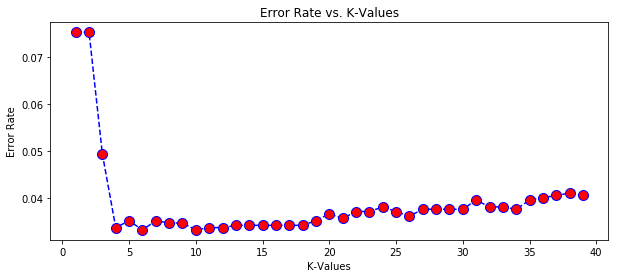

In [23]:
knn_nneighbors_analysis( XX[0], yy[0] )

In [26]:
knn_analysis( XX[0], yy[0], 4 )

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1035
           1       0.98      0.96      0.97      1013

   micro avg       0.97      0.97      0.97      2048
   macro avg       0.97      0.97      0.97      2048
weighted avg       0.97      0.97      0.97      2048

Accuracy Rate:  0.96630859375
Misclassification Rate: 0.03369140625

TP - True Negative 1011
FP - False Positive 24
FN - False Negative 45
TP - True Positive 968


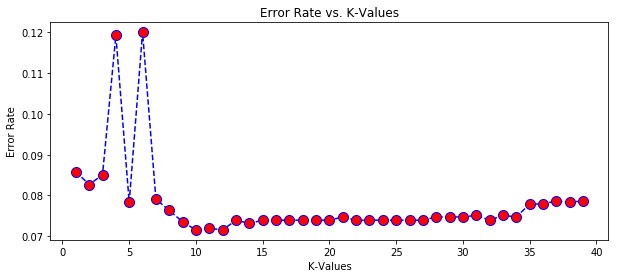

In [24]:
knn_nneighbors_analysis( XX[1], yy[1] )

In [28]:
knn_analysis( XX[1], yy[1], 10 )

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1041
           1       0.95      0.92      0.94      1475

   micro avg       0.93      0.93      0.93      2516
   macro avg       0.92      0.93      0.93      2516
weighted avg       0.93      0.93      0.93      2516

Accuracy Rate:  0.9284578696343402
Misclassification Rate: 0.0715421303657

TP - True Negative 972
FP - False Positive 69
FN - False Negative 111
TP - True Positive 1364


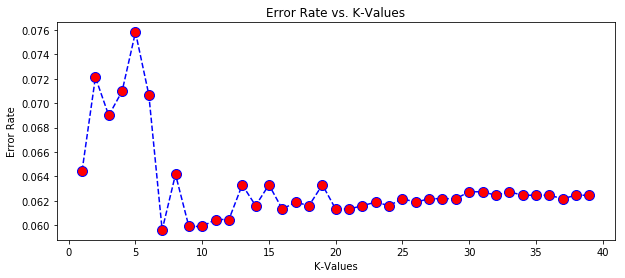

In [29]:
knn_nneighbors_analysis( XX[2], yy[2] )

In [30]:
knn_analysis( XX[2], yy[2], 7 )

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1046
           1       0.97      0.95      0.96      2476

   micro avg       0.94      0.94      0.94      3522
   macro avg       0.92      0.93      0.93      3522
weighted avg       0.94      0.94      0.94      3522

Accuracy Rate:  0.9403747870528109
Misclassification Rate: 0.0596252129472

TP - True Negative 964
FP - False Positive 82
FN - False Negative 128
TP - True Positive 2348


# Saving the best models

In [6]:
def generate_model( X, y, name ):
    # first we create a reusable logisitic regression and random forest objects
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    rf_clf.fit( X, y ) # train object
    # save the model to disk
    if not os.path.exists( 'models' ):
        os.makedirs( 'models' )
    str_ = 'models/randomForest_' + name + '_model.sav'
    print( "Saving the model into the disk\n" )
    joblib.dump( rf_clf, str_ )

In [7]:
names = [ 'fakeFollowers', 'spamBots', 'mix' ]
for i in range( len( names ) ):
    print( "Creating a model to detect:" + names[i] )
    generate_model( XX[i], yy[i], names[i] )

Creating a model to detect:fakeFollowers
Saving the model into the disk

Creating a model to detect:spamBots
Saving the model into the disk

Creating a model to detect:mix
Saving the model into the disk



# Neural Network analysis

In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

1.13.1


In [9]:
#Setting up the model layers
#https://www.tensorflow.org/api_docs/python/tf/keras/layers
#https://www.tensorflow.org/tutorials/keras/basic_classification

model = keras.Sequential( [ keras.layers.Dense( 32, input_shape=( len(X[0]), ) ),
                            keras.layers.Dense( 40, activation = tf.nn.sigmoid ),
                            keras.layers.Dense( 10, activation = tf.nn.sigmoid ),
                            keras.layers.Dense( 2, activation = tf.nn.softmax ) ] )

#the optimazer has to minimize the loss function

#Compiling the model
  #Loss function — This measures how accurate the model is during training. We want to minimize 
                   #this function to "steer" the model in the right direction.
  #Optimizer — This is how the model is updated based on the data it sees and its loss function.
  #Metrics —  Used to monitor the training and testing steps. The following example uses accuracy,
              #the fraction of the images that are correctly classified.
model.compile( optimizer = keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error', metrics = ['accuracy'] )
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_cv_iterations = 1
cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size = 0.2 )
iter_num = 1

for train_indices, test_indices in cv_object.split( X, y ):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    print "\n\n====Iteration",iter_num," ===="
    
    model.fit( X_train, y_train, epochs=1000 )
    test_loss, test_acc = model.evaluate( X_test, y_test )
    y_pred = model.predict( X_test )
    aux=[]
    for i in range( len( y_pred ) ):
        aux += [ np.argmax( y_pred[i] ) ]
    conf = mt.confusion_matrix( y_test, aux )
    
    print '\nMODEL RESULTS\n\tTest accuracy: ', test_acc, 'Test loss: ', test_loss
    print "PREDICTION RESULTS"
    print "confusion matrix\n", conf
    tp = float( conf[1][1] )
    fp = float( conf[0][1] )
    fn = float( conf[1][0] )
    try:  
        precission = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2*precission*recall/(precission+recall)
    except ArithmeticError:  
        print ("Arithmetic exception raised." )
    else: 
        print "\tF1: ", f1, "\tPrecission: ", precission, "\tRecall: ", recall
    iter_num+=1

#print y_pred

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


====Iteration 1  ====
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
9389/9389 [==============================] - 1s 103us/sample - loss: 0.2524 - acc: 0.4033
Epoch 2/1000
9389/9389 [==============================] - 1s 78us/sample - loss: 0.2500 - acc: 0.3350
Epoch 3/1000
9389/9389 [==============================] - 1s 84us/sample - loss: 0.2500 - acc: 0.3326
Epoch 4/1000
9389/9389 [==============================] - 1s 73us/sample - loss: 0.2500 - acc: 0.3465
Epoch 5/1000
9389/9389 [==============================] - 1s 71us/sample - loss: 0.2500 - acc: 0.3395
Epoch 6/1000
9389/9389 [==============================] - 1s 71us/sample - loss: 0.2500 - acc: 0.3382
Epoch 7/1000
9389/9389 [==============================] - 1s 72us/sample - loss: 0.2500 - acc: 0.3199
Epoch 8/1000
9389/9389 [==============================] - 1s 74us/sample - loss: 0.2500 - acc

9389/9389 [==============================] - 1s 66us/sample - loss: 0.2500 - acc: 0.4957
Epoch 73/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5062
Epoch 74/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4958
Epoch 75/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4950
Epoch 76/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.5066
Epoch 77/1000
9389/9389 [==============================] - 1s 78us/sample - loss: 0.2500 - acc: 0.5068
Epoch 78/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4946
Epoch 79/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5086
Epoch 80/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5079
Epoch 81/1000
9389/9389 [==============================] - 1s 67us/sample - loss: 0.250

9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5068
Epoch 152/1000
9389/9389 [==============================] - 1s 63us/sample - loss: 0.2500 - acc: 0.5024
Epoch 153/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5116
Epoch 154/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.5017
Epoch 155/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5004
Epoch 156/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 157/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5038
Epoch 158/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 159/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.4923
Epoch 160/1000
9389/9389 [==============================] - 1s 63us/sample - lo

9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4947
Epoch 230/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4991
Epoch 231/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5007
Epoch 232/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5053
Epoch 233/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5053
Epoch 234/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4934
Epoch 235/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5008
Epoch 236/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4946
Epoch 237/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4987
Epoch 238/1000
9389/9389 [==============================] - 1s 59us/sample - lo

9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5064
Epoch 308/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5001
Epoch 309/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5094
Epoch 310/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5076
Epoch 311/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5026
Epoch 312/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.4990
Epoch 313/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5066
Epoch 314/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4966
Epoch 315/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5087
Epoch 316/1000
9389/9389 [==============================] - 1s 61us/sample - lo

9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4941
Epoch 386/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5073
Epoch 387/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4916
Epoch 388/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5014
Epoch 389/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5019
Epoch 390/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4903
Epoch 391/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4998
Epoch 392/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.5024
Epoch 393/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5062
Epoch 394/1000
9389/9389 [==============================] - 1s 62us/sample - lo

9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4976
Epoch 464/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5071
Epoch 465/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5031
Epoch 466/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4944
Epoch 467/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4932
Epoch 468/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.5013
Epoch 469/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5019
Epoch 470/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 471/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5050
Epoch 472/1000
9389/9389 [==============================] - 1s 60us/sample - lo

9389/9389 [==============================] - 1s 63us/sample - loss: 0.2500 - acc: 0.4952
Epoch 542/1000
9389/9389 [==============================] - 1s 63us/sample - loss: 0.2500 - acc: 0.5089
Epoch 543/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5006
Epoch 544/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5023
Epoch 545/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4917
Epoch 546/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5021
Epoch 547/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.4973
Epoch 548/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4985
Epoch 549/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.4979
Epoch 550/1000
9389/9389 [==============================] - 1s 60us/sample - lo

9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.4971
Epoch 620/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4881
Epoch 621/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5009
Epoch 622/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5043
Epoch 623/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.4978
Epoch 624/1000
9389/9389 [==============================] - 1s 62us/sample - loss: 0.2500 - acc: 0.4848
Epoch 625/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5066
Epoch 626/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4968
Epoch 627/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4994
Epoch 628/1000
9389/9389 [==============================] - 1s 59us/sample - lo

9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5015
Epoch 698/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.5003
Epoch 699/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4965
Epoch 700/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4961
Epoch 701/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4925
Epoch 702/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5113
Epoch 703/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5012
Epoch 704/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4975
Epoch 705/1000
9389/9389 [==============================] - 1s 57us/sample - loss: 0.2500 - acc: 0.4948
Epoch 706/1000
9389/9389 [==============================] - 1s 58us/sample - lo

9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5027
Epoch 776/1000
9389/9389 [==============================] - 1s 67us/sample - loss: 0.2500 - acc: 0.4986
Epoch 777/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4955
Epoch 778/1000
9389/9389 [==============================] - 1s 60us/sample - loss: 0.2500 - acc: 0.4954
Epoch 779/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5029
Epoch 780/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4998
Epoch 781/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4982
Epoch 782/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4980
Epoch 783/1000
9389/9389 [==============================] - 1s 57us/sample - loss: 0.2500 - acc: 0.5074
Epoch 784/1000
9389/9389 [==============================] - 1s 64us/sample - lo

9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5003
Epoch 854/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4980
Epoch 855/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4944
Epoch 856/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5004
Epoch 857/1000
9389/9389 [==============================] - 1s 63us/sample - loss: 0.2500 - acc: 0.4993
Epoch 858/1000
9389/9389 [==============================] - 1s 63us/sample - loss: 0.2500 - acc: 0.5045
Epoch 859/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.5074
Epoch 860/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4996
Epoch 861/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.4943
Epoch 862/1000
9389/9389 [==============================] - 1s 59us/sample - lo

9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4976
Epoch 932/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4991
Epoch 933/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.4981
Epoch 934/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5041
Epoch 935/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4954
Epoch 936/1000
9389/9389 [==============================] - 1s 61us/sample - loss: 0.2500 - acc: 0.5014
Epoch 937/1000
9389/9389 [==============================] - 1s 64us/sample - loss: 0.2500 - acc: 0.5028
Epoch 938/1000
9389/9389 [==============================] - 1s 59us/sample - loss: 0.2500 - acc: 0.4928
Epoch 939/1000
9389/9389 [==============================] - 1s 58us/sample - loss: 0.2500 - acc: 0.5043
Epoch 940/1000
9389/9389 [==============================] - 1s 62us/sample - lo